Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
!pip install tensorflow==2.8.0

In [98]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [99]:
tf.__version__

'2.8.0'

In [100]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [101]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [102]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [103]:
batch_size = 32
img_height = 180
img_width = 180

In [104]:
tf.__version__

'2.8.0'

Use 80% of the images for training, and 20% for validation.

In [105]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [106]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [107]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

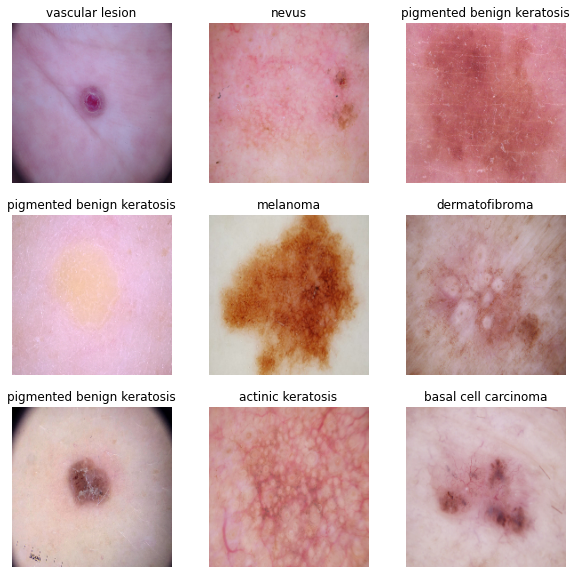

In [108]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1):
     for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [109]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Model M1

In [110]:
### Your code goes here
num_classes=9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [111]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [112]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [113]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 63s 931ms/step - loss: 1.9023 - accuracy: 0.2835 - val_loss: 1.7010 - val_accuracy: 0.4452
Epoch 2/20
56/56 [==============================] - 51s 921ms/step - loss: 1.4842 - accuracy: 0.4821 - val_loss: 1.4510 - val_accuracy: 0.5302
Epoch 3/20
56/56 [==============================] - 50s 894ms/step - loss: 1.3704 - accuracy: 0.5301 - val_loss: 1.4631 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 51s 918ms/step - loss: 1.3415 - accuracy: 0.5396 - val_loss: 1.4552 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 50s 900ms/step - loss: 1.2064 - accuracy: 0.5737 - val_loss: 1.4589 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 51s 911ms/step - loss: 1.1191 - accuracy: 0.6038 - val_loss: 1.3517 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 49s 876ms/step - loss: 1.1179 - accuracy: 0.6027 - val_loss: 1.3754 - val_accuracy: 0.5414

### Visualizing training results

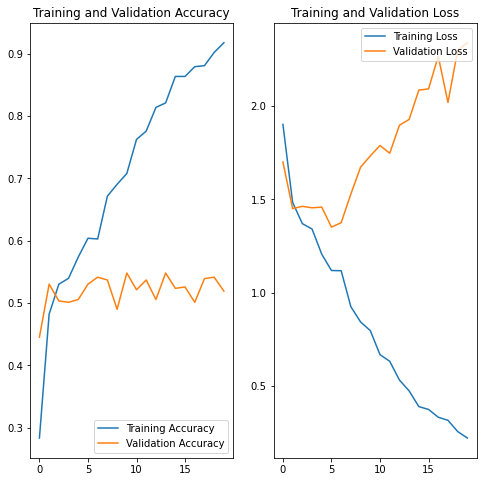

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Observation:

From the graph as well as from the epoch details we can see there is a huge difference between training and validation accuracy. and the model seem to have overfitted on training data.

In [115]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

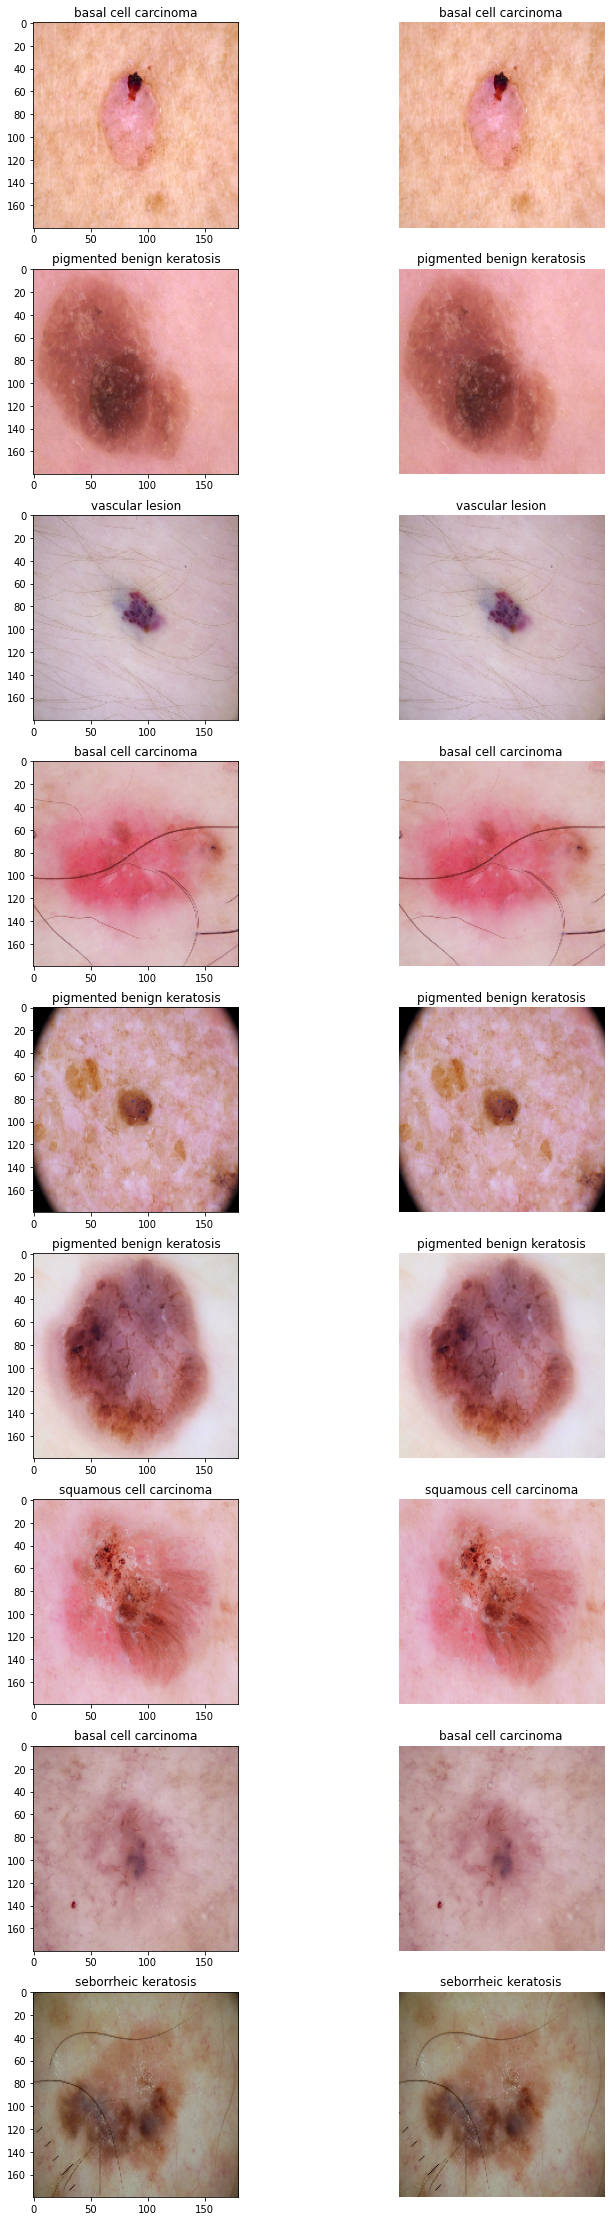

In [116]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 40))
for images, labels in list(train_ds.take(1)):
  augmented_image = data_augmentation(images)
  j=1
  for i in range(9):
    ax = plt.subplot(9, 2, j)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    j+=1

    ax = plt.subplot(9, 2, j)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    j+=1

  plt.show()

### Todo:
### Create the model, compile and train the model

### Model M2


In [117]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
num_classes=9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])



### Compiling the model

In [118]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [119]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 56s 994ms/step - loss: 2.1320 - accuracy: 0.2020 - val_loss: 2.0090 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: 1.9081 - accuracy: 0.3058 - val_loss: 1.8489 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 60s 1s/step - loss: 1.6945 - accuracy: 0.3923 - val_loss: 1.7153 - val_accuracy: 0.3803
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 1.6238 - accuracy: 0.4291 - val_loss: 1.5241 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 60s 1s/step - loss: 1.5162 - accuracy: 0.4693 - val_loss: 1.4967 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 59s 1s/step - loss: 1.4067 - accuracy: 0.5028 - val_loss: 1.5721 - val_accuracy: 0.4161
Epoch 7/20
56/56 [==============================] - 60s 1s/step - loss: 1.3410 - accuracy: 0.5240 - val_loss: 1.3944 - val_accuracy: 0.5280
Epoch 8/20
56/56 

### Visualizing the results

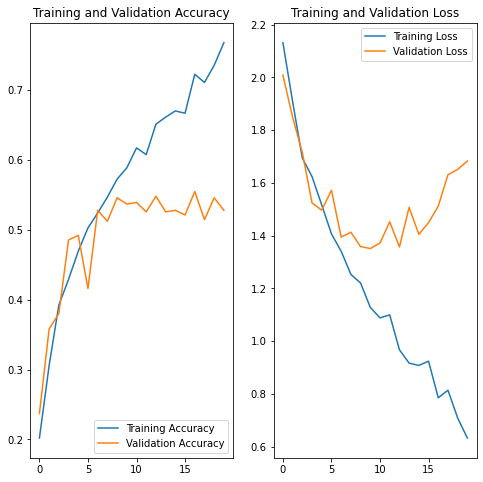

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1- Training accuracy decreases.

2- The training and validation accuracy gap has reduced.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [122]:
## Your code goes here.
df  = []
for i in class_names:
  path_list = [x for x in data_dir_train.glob(i+'/*.jpg')]
  df.append(len(path_list))
df = pd.DataFrame(list(zip(class_names,df)),columns=["class","counts"])
print(df)

                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


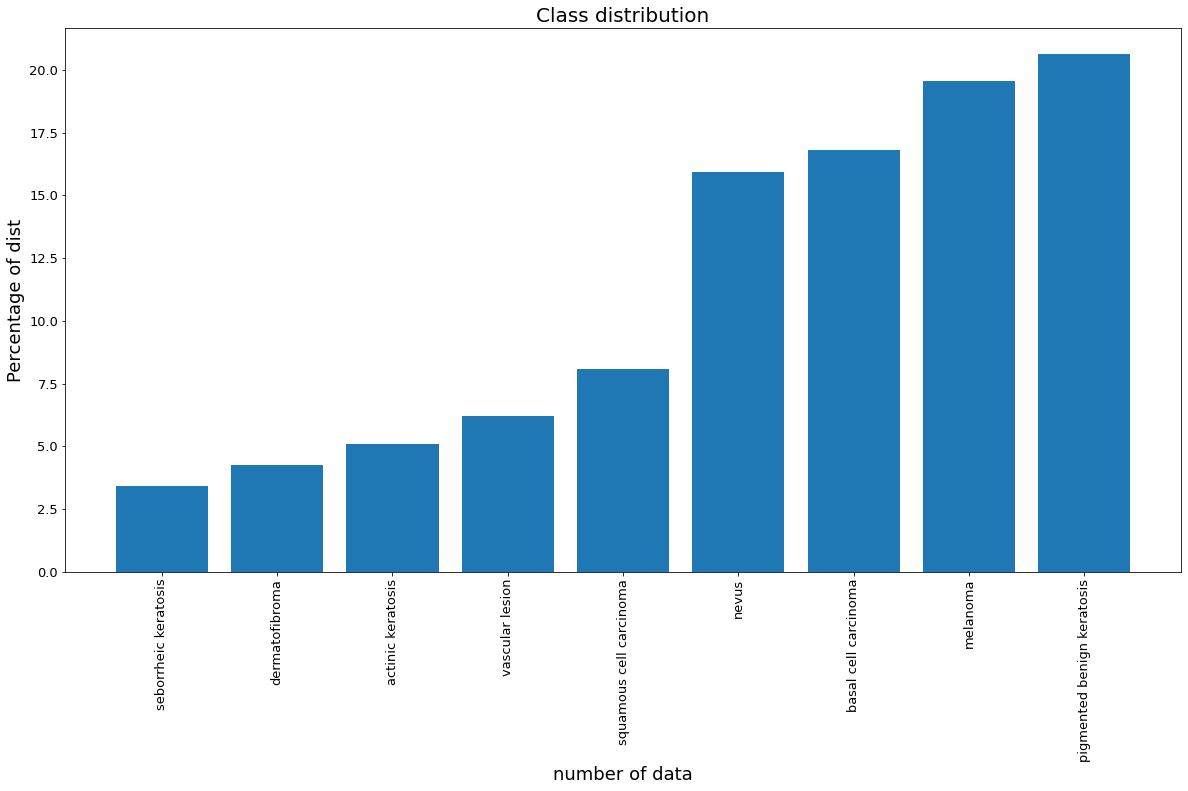

In [123]:
df['counts'] = (df['counts']/sum(df.counts))*100
df.sort_values(by="counts",inplace=True)
plt.figure(figsize=(20,10))
plt.bar(x = df["class"],height=df['counts'])
plt.yticks(fontsize=13)
plt.xlabel('number of data',fontsize = 18)
plt.ylabel('Percentage of dist',fontsize = 18)
plt.title('Class distribution',fontsize=20)
plt.xticks(fontsize = 13,rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

seborrheic keratosis has only 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis,basal cell carcinoma,melonoma and nevus dominates the data in terms of proportion.


In [124]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("path_list: ",len(path_list))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(lesion_list))

path_list:  2239
lesion_list:  2239


In [125]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df
original_df.count


<bound method DataFrame.count of                                           Path              Label
0     Train\actinic keratosis\ISIC_0025780.jpg  actinic keratosis
1     Train\actinic keratosis\ISIC_0025803.jpg  actinic keratosis
2     Train\actinic keratosis\ISIC_0025825.jpg  actinic keratosis
3     Train\actinic keratosis\ISIC_0025953.jpg  actinic keratosis
4     Train\actinic keratosis\ISIC_0025957.jpg  actinic keratosis
...                                        ...                ...
2234    Train\vascular lesion\ISIC_0033844.jpg    vascular lesion
2235    Train\vascular lesion\ISIC_0033969.jpg    vascular lesion
2236    Train\vascular lesion\ISIC_0033991.jpg    vascular lesion
2237    Train\vascular lesion\ISIC_0034196.jpg    vascular lesion
2238    Train\vascular lesion\ISIC_0034214.jpg    vascular lesion

[2239 rows x 2 columns]>

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [126]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [127]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2B397B95C70>:   0%| | 1/500 [00:00<01:08

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B394BD18E0>: 100%|█| 500/500 [00:09<00:00, 53.81 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B397A78580>:   0%| | 2/500 [00:00<00:35, 14.01 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B39B9903D0>: 100%|█| 500/500 [00:10<00:00, 47.41 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2B397B95820>:   0%| | 0/500 [00:00<?, ? 

Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B39986F5B0>: 100%|█| 500/500 [00:11<00:00, 45.19 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2B397AADD90>:   0%| | 0/500 [00:00<?, ?

Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2B39B9A3BE0>: 100%|█| 500/500 [00:53<00:00,  9.26 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=959x634 at 0x2B394BD18E0>: 100%|█| 500/500 [00:49<00:00, 10.18 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B39B9A3EB0>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2B39B9B16A0>: 100%|█| 500/500 [00:12<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2B39239FE20>: 100%|█| 500/500 [00:27<00:00, 17.91 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B397AF6190>:   0%| | 2/500 [00:00<00:43, 11.32 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B3901C28B0>: 100%|█| 500/500 [00:11<00:00, 41.79 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B397B05790>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B397ACE0A0>: 100%|█| 500/500 [00:12<00:00, 40.52 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [128]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [129]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7fac2d2a-667a-41fc-b808-fa84094a9cd5.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_855c9065-cfd3-4b3a-847b-f98a83e99b0d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a0eddb07-f3ab-42d4-82a4-9bd3414992e6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b1cc3467-3f32-4ca5-a8da-d116feb95de6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_cd99bdb5-ad1c-4a33-82a2-42eea8844c21.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1de12127-cf64-42c0-bea7-69acc086a2da.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4d27fd83-02dc-4ace-b18c-b08d2835fe84.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_c93690d9-26e0-416d-b3ed-08a61a5195ab.jpg',
 'Train\\actinic

In [130]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [131]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [132]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [133]:
new_df

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
4495,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4496,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4497,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4498,Train\vascular lesion\output\vascular lesion_o...,vascular lesion


In [134]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [135]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [137]:
data_dir_train="Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [138]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

### Model M3

In [142]:
## your code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [144]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [145]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 281s 2s/step - loss: 2.6707 - accuracy: 0.3092 - val_loss: 74.4953 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 269s 2s/step - loss: 1.4417 - accuracy: 0.4585 - val_loss: 25.9271 - val_accuracy: 0.1151
Epoch 3/30
169/169 [==============================] - 271s 2s/step - loss: 1.1827 - accuracy: 0.5495 - val_loss: 19.1192 - val_accuracy: 0.1552
Epoch 4/30
169/169 [==============================] - 266s 2s/step - loss: 1.0225 - accuracy: 0.6139 - val_loss: 2.8156 - val_accuracy: 0.3445
Epoch 5/30
169/169 [==============================] - 266s 2s/step - loss: 0.8660 - accuracy: 0.6675 - val_loss: 5.5007 - val_accuracy: 0.4068
Epoch 6/30
169/169 [==============================] - 266s 2s/step - loss: 0.7530 - accuracy: 0.7122 - val_loss: 1.5701 - val_accuracy: 0.5679
Epoch 7/30
169/169 [==============================] - 266s 2s/step - loss: 0.6395 - accuracy: 0.7587 - val_loss: 2.1722 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

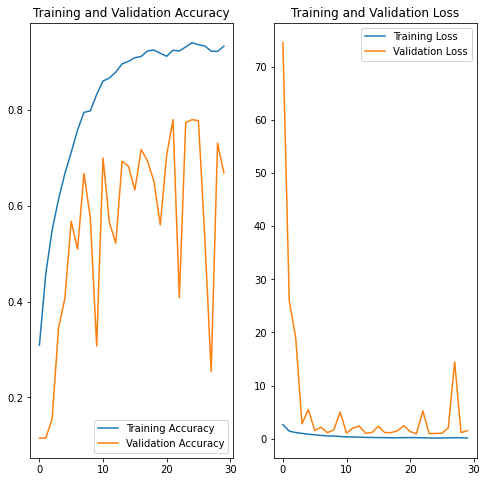

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

As observed above,there is a considerable decrease in the value difference of accuracy of training data(93%) and validation data(67%).

Thus overfitting is handled to certain extent.



### Model M4


In [148]:
## Let try by changing the model structure a bit

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])


In [151]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 90, 90, 32)      

In [152]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 528s 3s/step - loss: 1.8900 - accuracy: 0.3259 - val_loss: 7.6492 - val_accuracy: 0.1537
Epoch 2/30
169/169 [==============================] - 518s 3s/step - loss: 1.5506 - accuracy: 0.4175 - val_loss: 3.4048 - val_accuracy: 0.2509
Epoch 3/30
169/169 [==============================] - 523s 3s/step - loss: 1.4612 - accuracy: 0.4546 - val_loss: 2.0131 - val_accuracy: 0.3311
Epoch 4/30
169/169 [==============================] - 520s 3s/step - loss: 1.3822 - accuracy: 0.4774 - val_loss: 2.3773 - val_accuracy: 0.3215
Epoch 5/30
169/169 [==============================] - 517s 3s/step - loss: 1.2725 - accuracy: 0.5137 - val_loss: 1.4011 - val_accuracy: 0.4699
Epoch 6/30
169/169 [==============================] - 514s 3s/step - loss: 1.1660 - accuracy: 0.5532 - val_loss: 1.1955 - val_accuracy: 0.5308
Epoch 7/30
169/169 [==============================] - 517s 3s/step - loss: 1.0622 - accuracy: 0.6001 - val_loss: 1.7167 - val_accuracy: 0.3942

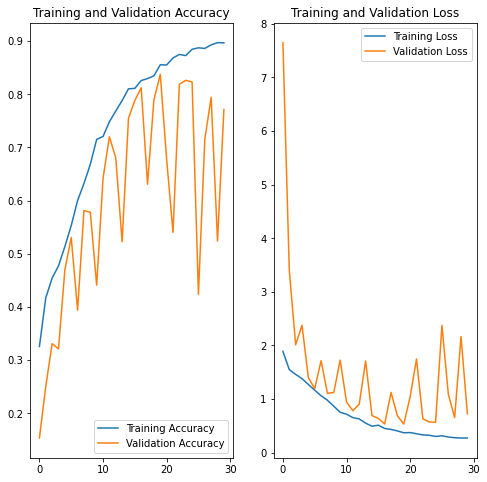

In [153]:
#visualize the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Observation :

With the above diagram and values we can that there is no overfitting as the difference in accuracy on validation and training set is low.

Model M4 is the final model.